In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 520

ng =8

ng_adju = (/ 0 , -1 /) 

ng_refs = (/ 3 , 2 , 3 /) 

nref =3

nv = 1000

option_compute_btable =0

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 1380

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66/

data wgt
     &     /0.55 , 0.55 , 0.85 , 0.85,
     &     0.85 , 0.0 , 0.3 , 0.55/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

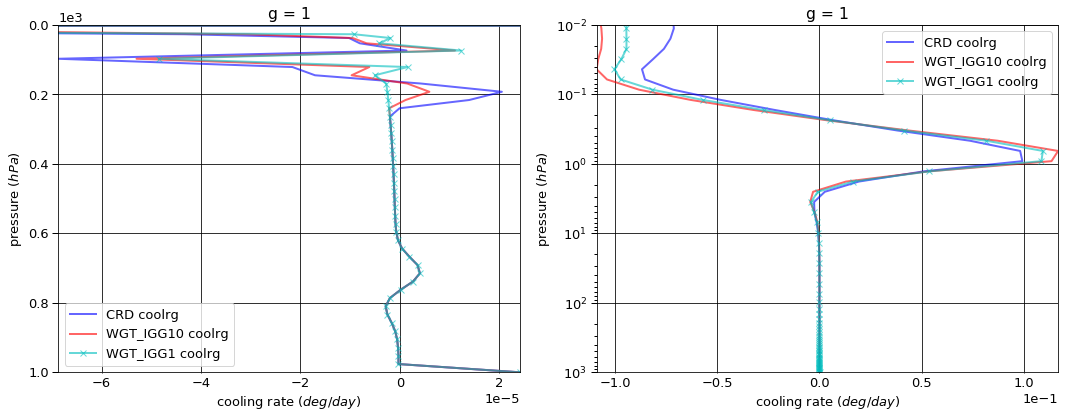

# Figure: cooling rate g-group 2

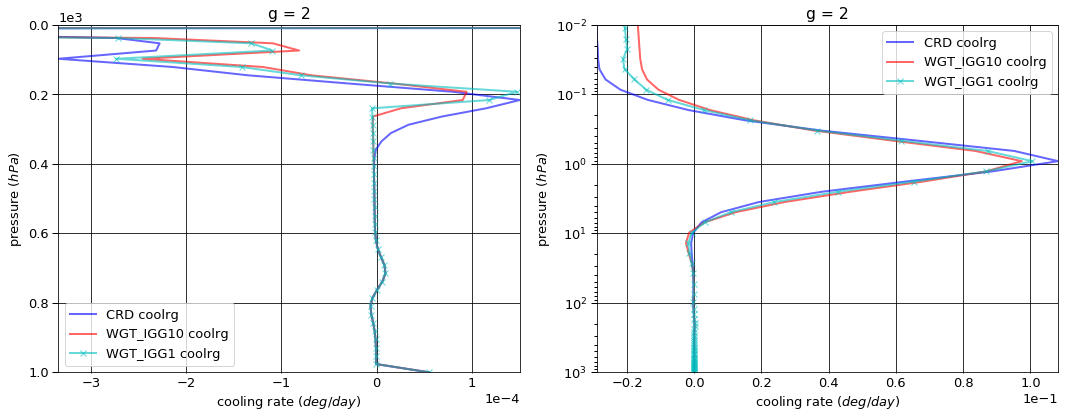

# Figure: cooling rate g-group 3

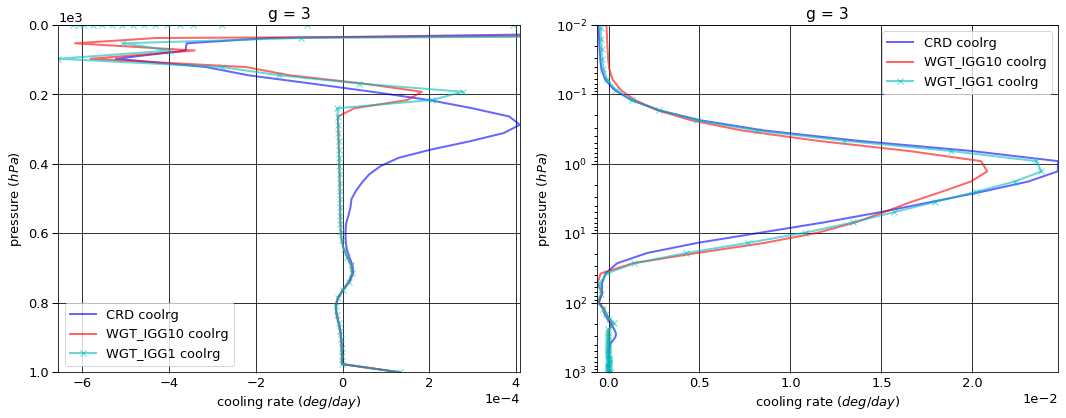

# Figure: cooling rate g-group 4

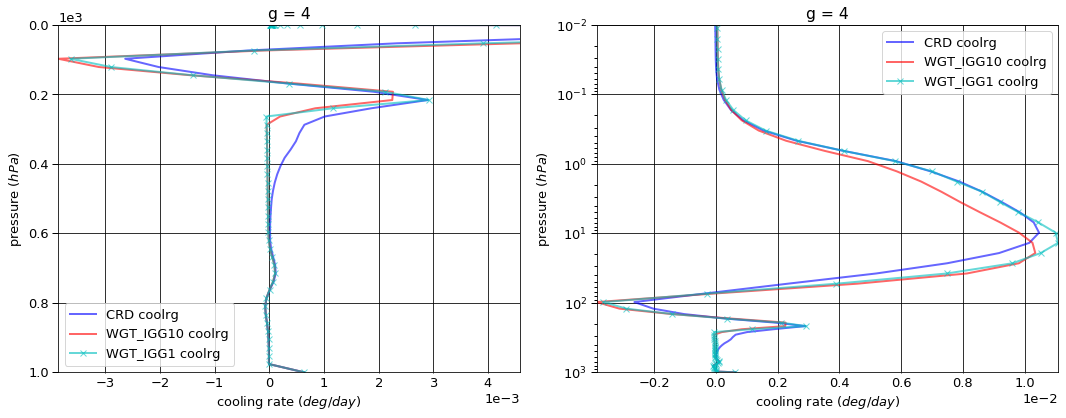

# Figure: cooling rate g-group 5

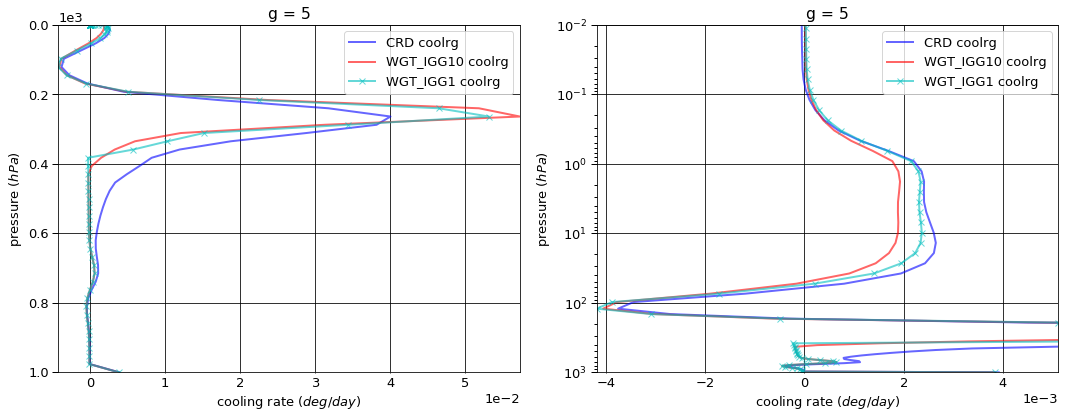

# Figure: cooling rate g-group 6

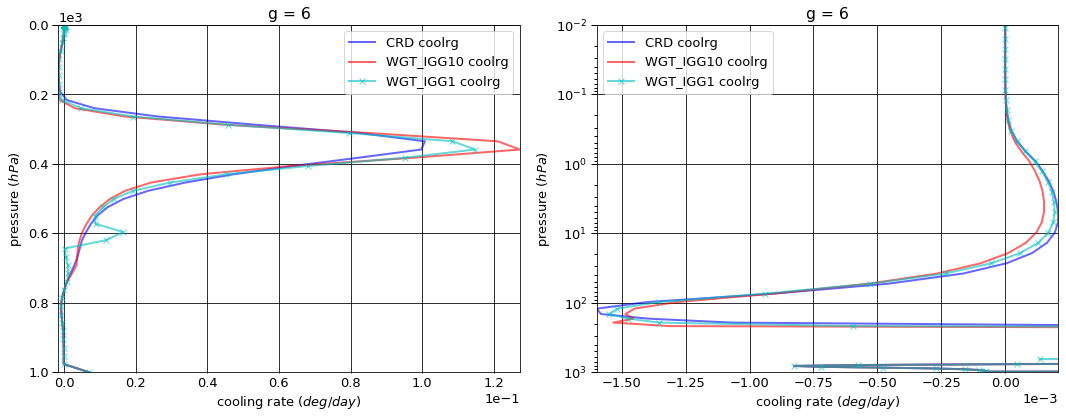

# Figure: cooling rate g-group 7

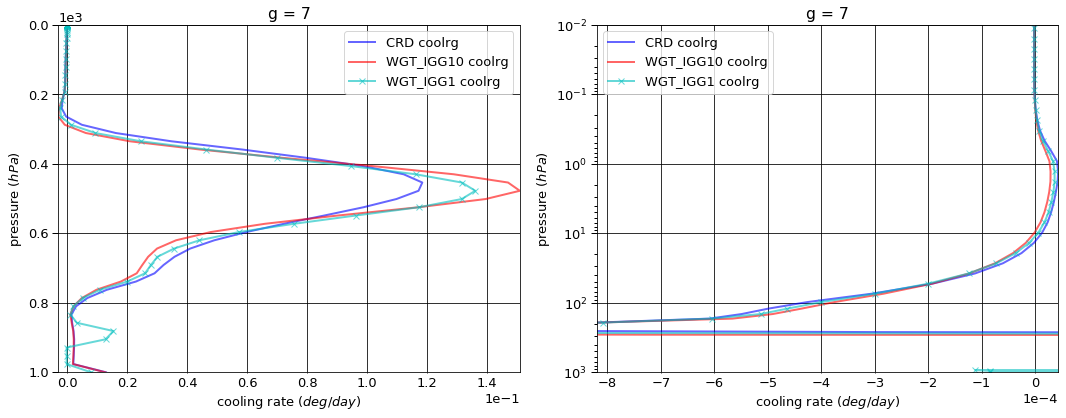

# Figure: cooling rate g-group 8

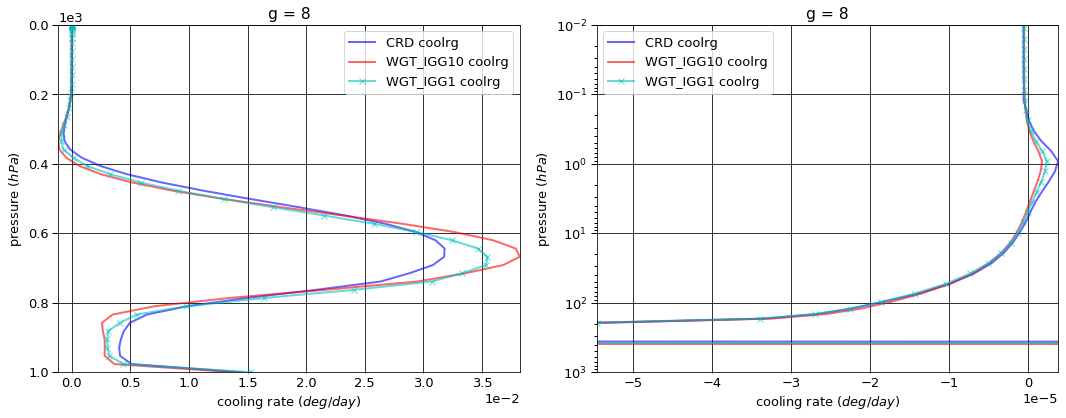

# Figure: cooling rate g-group total

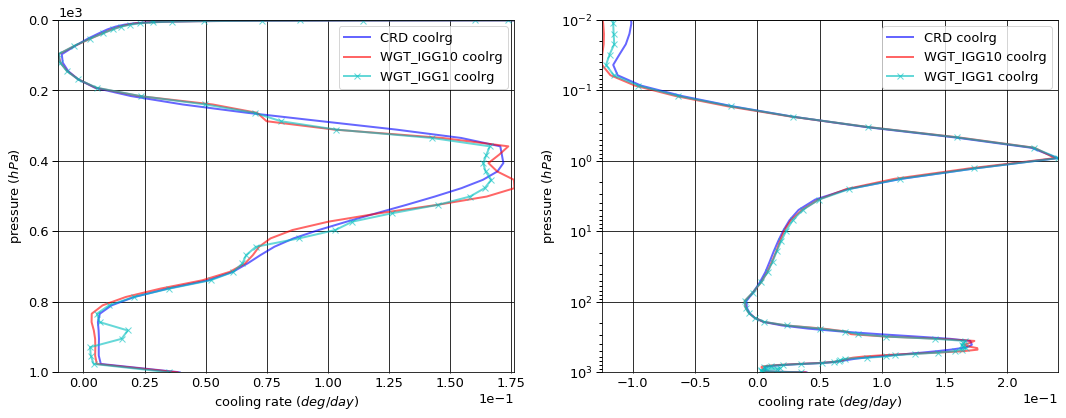

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009101   0.000000 -0.009101
  1013.0   76     -0.040341   0.040272 -0.000068
2 0.0      1      -0.021891   0.000000 -0.021891
  1013.0   76     -0.091678   0.091522 -0.000155
3 0.0      1      -0.026684   0.000000 -0.026684
  1013.0   76     -0.220321   0.219946 -0.000374
4 0.0      1      -0.063543   0.000000 -0.063543
  1013.0   76     -1.061244   1.059444 -0.001800
5 0.0      1      -0.648548   0.000000 -0.648548
  1013.0   76     -6.411048   6.399978 -0.011070
6 0.0      1      -1.960944   0.000000 -1.960944
  1013.0   76    -11.699923  11.680042 -0.019881
7 0.0      1      -3.751475   0.000000 -3.751475
  1013.0   76    -13.521026  13.486870 -0.034156
8 0.0      1      -1.211070   0.000000 -1.211070
  1013.0   76     -2.809452   2.758799 -0.050653


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009180   0.000000 -0.009180
  1013.0   76     -0.040341   0.040272 -0.000068
2 0.0      1      -0.023131   0.000000 -0.023131
  1013.0   76     -0.091678   0.091522 -0.000155
3 0.0      1      -0.025338   0.000000 -0.025338
  1013.0   76     -0.220321   0.219946 -0.000374
4 0.0      1      -0.052368   0.000000 -0.052368
  1013.0   76     -1.061244   1.059444 -0.001800
5 0.0      1      -0.529731   0.000000 -0.529731
  1013.0   76     -6.411048   6.400191 -0.010857
6 0.0      1      -1.971538   0.000000 -1.971538
  1013.0   76    -11.699923  11.680042 -0.019881
7 0.0      1      -3.759917   0.000000 -3.759917
  1013.0   76    -13.521026  13.487699 -0.033327
8 0.0      1      -1.209505   0.000000 -1.209505
  1013.0   76     -2.809452   2.769057 -0.040395


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009162   0.000000 -0.009162
  1013.0   76     -0.040341   0.040272 -0.000068
2 0.0      1      -0.022661   0.000000 -0.022661
  1013.0   76     -0.091678   0.091522 -0.000155
3 0.0      1      -0.025607   0.000000 -0.025607
  1013.0   76     -0.220321   0.219946 -0.000374
4 0.0      1      -0.053971   0.000000 -0.053971
  1013.0   76     -1.061244   1.059444 -0.001800
5 0.0      1      -0.534049   0.000000 -0.534049
  1013.0   76     -6.411048   6.400191 -0.010857
6 0.0      1      -1.987657   0.000000 -1.987657
  1013.0   76    -11.699923  11.680042 -0.019881
7 0.0      1      -3.799461   0.000000 -3.799461
  1013.0   76    -13.521026  13.498315 -0.022712
8 0.0      1      -1.219416   0.000000 -1.219416
  1013.0   76     -2.809452   2.762535 -0.046917


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -7.884100e-05  0.000000e+00 -7.884100e-05
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1     -1.239125e-03  0.000000e+00 -1.239125e-03
  1013.0   76     1.387779e-17  0.000000e+00  0.000000e+00
3 0.0      1      1.345659e-03  0.000000e+00  1.345659e-03
  1013.0   76     0.000000e+00  0.000000e+00 -5.421011e-20
4 0.0      1      1.117555e-02  0.000000e+00  1.117555e-02
  1013.0   76     0.000000e+00  6.000000e-07  6.347000e-07
5 0.0      1      1.188174e-01  0.000000e+00  1.188174e-01
  1013.0   76    -8.881784e-16  2.134000e-04  2.134070e-04
6 0.0      1     -1.059390e-02  0.000000e+00 -1.059390e-02
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7 0.0      1     -8.441800e-03  0.000000e+00 -8.441800e-03
  1013.0   76     0.000000e+00  8.290000e-04  8.292930e-04
8 0.0      1      1.564800e-03  0.000000e+00  1.564800e-03
  1013.0   76     0.000000e+00  1.025830e-02  1.025834e-02


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -6.046760e-05  0.000000e+00 -6.046760e-05
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1     -7.695310e-04  0.000000e+00 -7.695310e-04
  1013.0   76     1.387779e-17  0.000000e+00  0.000000e+00
3 0.0      1      1.076905e-03  0.000000e+00  1.076905e-03
  1013.0   76     0.000000e+00  0.000000e+00 -5.421011e-20
4 0.0      1      9.572398e-03  0.000000e+00  9.572398e-03
  1013.0   76     0.000000e+00  6.000000e-07  6.347000e-07
5 0.0      1      1.144993e-01  0.000000e+00  1.144993e-01
  1013.0   76    -8.881784e-16  2.134000e-04  2.134070e-04
6 0.0      1     -2.671310e-02  0.000000e+00 -2.671310e-02
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7 0.0      1     -4.798600e-02  0.000000e+00 -4.798600e-02
  1013.0   76     0.000000e+00  1.144500e-02  1.144443e-02
8 0.0      1     -8.345500e-03  0.000000e+00 -8.345500e-03
  1013.0   76     0.000000e+00  3.736800e-03  3.736772e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -8.555547e-02
  1001.112500 75     2.415395e-05
2 0.000312    1     -3.098242e-02
  1001.112500 75     5.485877e-05
3 0.000312    1     -7.514086e-04
  1001.112500 75     1.321281e-04
4 0.000312    1     -4.230903e-05
  1001.112500 75     6.353438e-04
5 0.000312    1     -7.395349e-05
  1001.112500 75     3.916002e-03
6 0.000312    1     -5.428795e-07
  1001.112500 75     7.015739e-03
7 0.000312    1     -1.812042e-06
  1001.112500 75     1.300415e-02
8 0.000312    1     -6.370054e-07
  1001.112500 75     1.457396e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.197450e-01
  1001.112500 75     2.415395e-05
2 0.000312    1     -1.816267e-02
  1001.112500 75     5.485877e-05
3 0.000312    1     -2.886485e-04
  1001.112500 75     1.321281e-04
4 0.000312    1      2.752691e-05
  1001.112500 75     6.351061e-04
5 0.000312    1     -5.139909e-07
  1001.112500 75     3.831682e-03
6 0.000312    1     -5.204243e-07
  1001.112500 75     7.015739e-03
7 0.000312    1     -1.525828e-06
  1001.112500 75     1.278113e-02
8 0.000312    1     -5.367824e-07
  1001.112500 75     1.400853e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.059841e-01
  1001.112500 75     2.415395e-05
2 0.000312    1     -2.228801e-02
  1001.112500 75     5.485877e-05
3 0.000312    1     -6.211870e-04
  1001.112500 75     1.321281e-04
4 0.000312    1      1.839709e-05
  1001.112500 75     6.351061e-04
5 0.000312    1      6.903887e-06
  1001.112500 75     3.831682e-03
6 0.000312    1     -5.118234e-07
  1001.112500 75     7.015739e-03
7 0.000312    1     -1.582939e-06
  1001.112500 75     8.016559e-03
8 0.000312    1     -5.644492e-07
  1001.112500 75     1.532609e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.418948e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.281975e-02
  1001.112500 75    -6.776264e-21
3 0.000312    1      4.627600e-04
  1001.112500 75     0.000000e+00
4 0.000312    1      6.983594e-05
  1001.112500 75    -2.376900e-07
5 0.000312    1      7.343950e-05
  1001.112500 75    -8.431950e-05
6 0.000312    1      2.245524e-08
  1001.112500 75     0.000000e+00
7 0.000312    1      2.862143e-07
  1001.112500 75    -2.230210e-04
8 0.000312    1      1.002230e-07
  1001.112500 75    -5.654350e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.042867e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      8.694406e-03
  1001.112500 75    -6.776264e-21
3 0.000312    1      1.302216e-04
  1001.112500 75     0.000000e+00
4 0.000312    1      6.070613e-05
  1001.112500 75    -2.376900e-07
5 0.000312    1      8.085738e-05
  1001.112500 75    -8.431950e-05
6 0.000312    1      3.105608e-08
  1001.112500 75     0.000000e+00
7 0.000312    1      2.291035e-07
  1001.112500 75    -4.987593e-03
8 0.000312    1      7.255626e-08
  1001.112500 75     7.521340e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.693258,0.000000,-7.693258
1013.0,76,-35.855033,35.736873,-0.118159



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.580708,0.000000,-7.580708
1013.0,76,-35.855033,35.748175,-0.106858



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.651984,0.000000,-7.651984
1013.0,76,-35.855033,35.752269,-0.102764



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.11255,0.000000,0.112550
1013.0,76,0.00000,0.011301,0.011302



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.041274,0.000000,0.041274
1013.0,76,0.000000,0.015396,0.015395


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.117409
1001.112500,75,0.039356



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.138172
1001.112500,75,0.038483



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.128871
1001.112500,75,0.035036



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.020763
1001.112500,75,-0.000873



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.011462
1001.112500,75,-0.004320


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001075,0.001121
2,0.002500,0.002556
3,0.006004,0.006115
4,0.028350,0.029532
5,0.170713,0.178816
6,0.317971,0.324777
7,0.364756,0.383420
8,0.108631,0.073663


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.712719e-18
2,3.036482e-19
3,1.956454e-20
4,6.326694e-21
5,2.056007e-22
6,1.045323e-21
7,1.065660e-22
8,1.086393e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.712719e-18,NaN,0.001075,0.001121,0.001075,0.001121,1.0
2,3.036482e-19,0.064432,0.002500,0.002556,0.003575,0.003677,1.0
3,1.956454e-20,0.064432,0.006004,0.006115,0.009579,0.009793,1.0
4,6.326694e-21,0.323376,0.028350,0.029532,0.037929,0.039324,10.0
5,2.056007e-22,0.032497,0.170713,0.178816,0.208642,0.218140,10.0
6,1.045323e-21,5.084237,0.317971,0.324777,0.526613,0.542917,500.0
7,1.065660e-22,0.101946,0.364756,0.383420,0.891369,0.926337,500.0
8,1.086393e-23,0.101946,0.108631,0.073663,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
